## Explanation of notebook

In this notebook, the objective is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. The task and dataset: https://www.kaggle.com/uciml/pima-indians-diabetes-database

### Feature information

- Number of times pregnant (**pregnant**)

- Plasma glucose concentration a 2 hours in an oral glucose tolerance test (**glucose**)

- Diastolic blood pressure (mm Hg) (**bp**)

- Triceps skin fold thickness (mm) (**skin**)

- 2-Hour serum insulin (mu U/ml) (**insulin**)

- Body mass index (weight in kg/(height in m)^2) (**bmi**)

- Diabetes pedigree function (**pedigree**)

- Age (years) (**age**)

- Class variable (0 or 1) (**label**)

In [1]:
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import uniform

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
target_col = 'label'

# data related
data_folder = 'data'
model_folder = 'model'
data_path = os.path.join(data_folder, 'diabetes.csv')

# reproduction purposes
SEED = 10
np.random.seed(SEED)

In [15]:
# prototyping functions
class RandomSearchOptimizer(object):
    '''Very fast prototyping of an optimizer based on random parameter space search'''
    
    def __init__(self, X_train, y_train, model, space):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.space = space
        self.best_model_ = None
        
    def optimize(self, scoring='accuracy', n_iter=100, n_folds=5, verbose=False):
        '''Optimize given model using randomized search cv'''
        
        optimizer = RandomizedSearchCV(self.model, self.space, scoring=scoring, random_state=1,
                                       n_iter=n_iter, cv=n_folds, verbose=verbose,
                                       n_jobs=-1)
        optimizer.fit(self.X_train, self.y_train)
        self.best_model_= optimizer.best_estimator_
        print(f'Scoring: {scoring} score: {optimizer.best_score_}\
        best params: {optimizer.best_params_}')
        
        if verbose:
            scores_df = pd.DataFrame(optimizer.cv_results_)
            scores_df = scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
            display(scores_df)

        return self.best_model_, optimizer.best_params_
    
    def predict(self, X_test, **optimize_args):
        '''Optimize the model for train data given on initilization and predict on test data'''
        best_model, _= self.optimize(**optimize_args)
        pred = best_model.predict(X_test)
        return pred
    
    def get_best_model(self):
        '''Return latest best optimized model if available else None'''
        return self.best_model_
              

def evaluate_model_cv(X_train, y_train, model, model_name, scoring='accuracy', n_folds=5):
    '''Evaluate a model using stratified kfold cross validation with given scoring'''
    kfold = StratifiedKFold(n_splits=n_folds, random_state=SEED)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    print(f'Model: {model_name} | Scoring: {scoring} score: {cv_results.mean()} std: {cv_results.std()}')
        
    return cv_results.mean()

def serialize_model(model, name):
    '''Pickle given model'''
    if model:
        serialization_path = os.path.join(model_folder, f'{name}.pkl')
        with open(serialization_path, 'wb') as f:
            pickle.dump(model, f)
    else:
        ValueError('No valid model given for pickling')

In [4]:
# load dataset
df = pd.read_csv(data_path, header=0, names=col_names)
df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   label     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


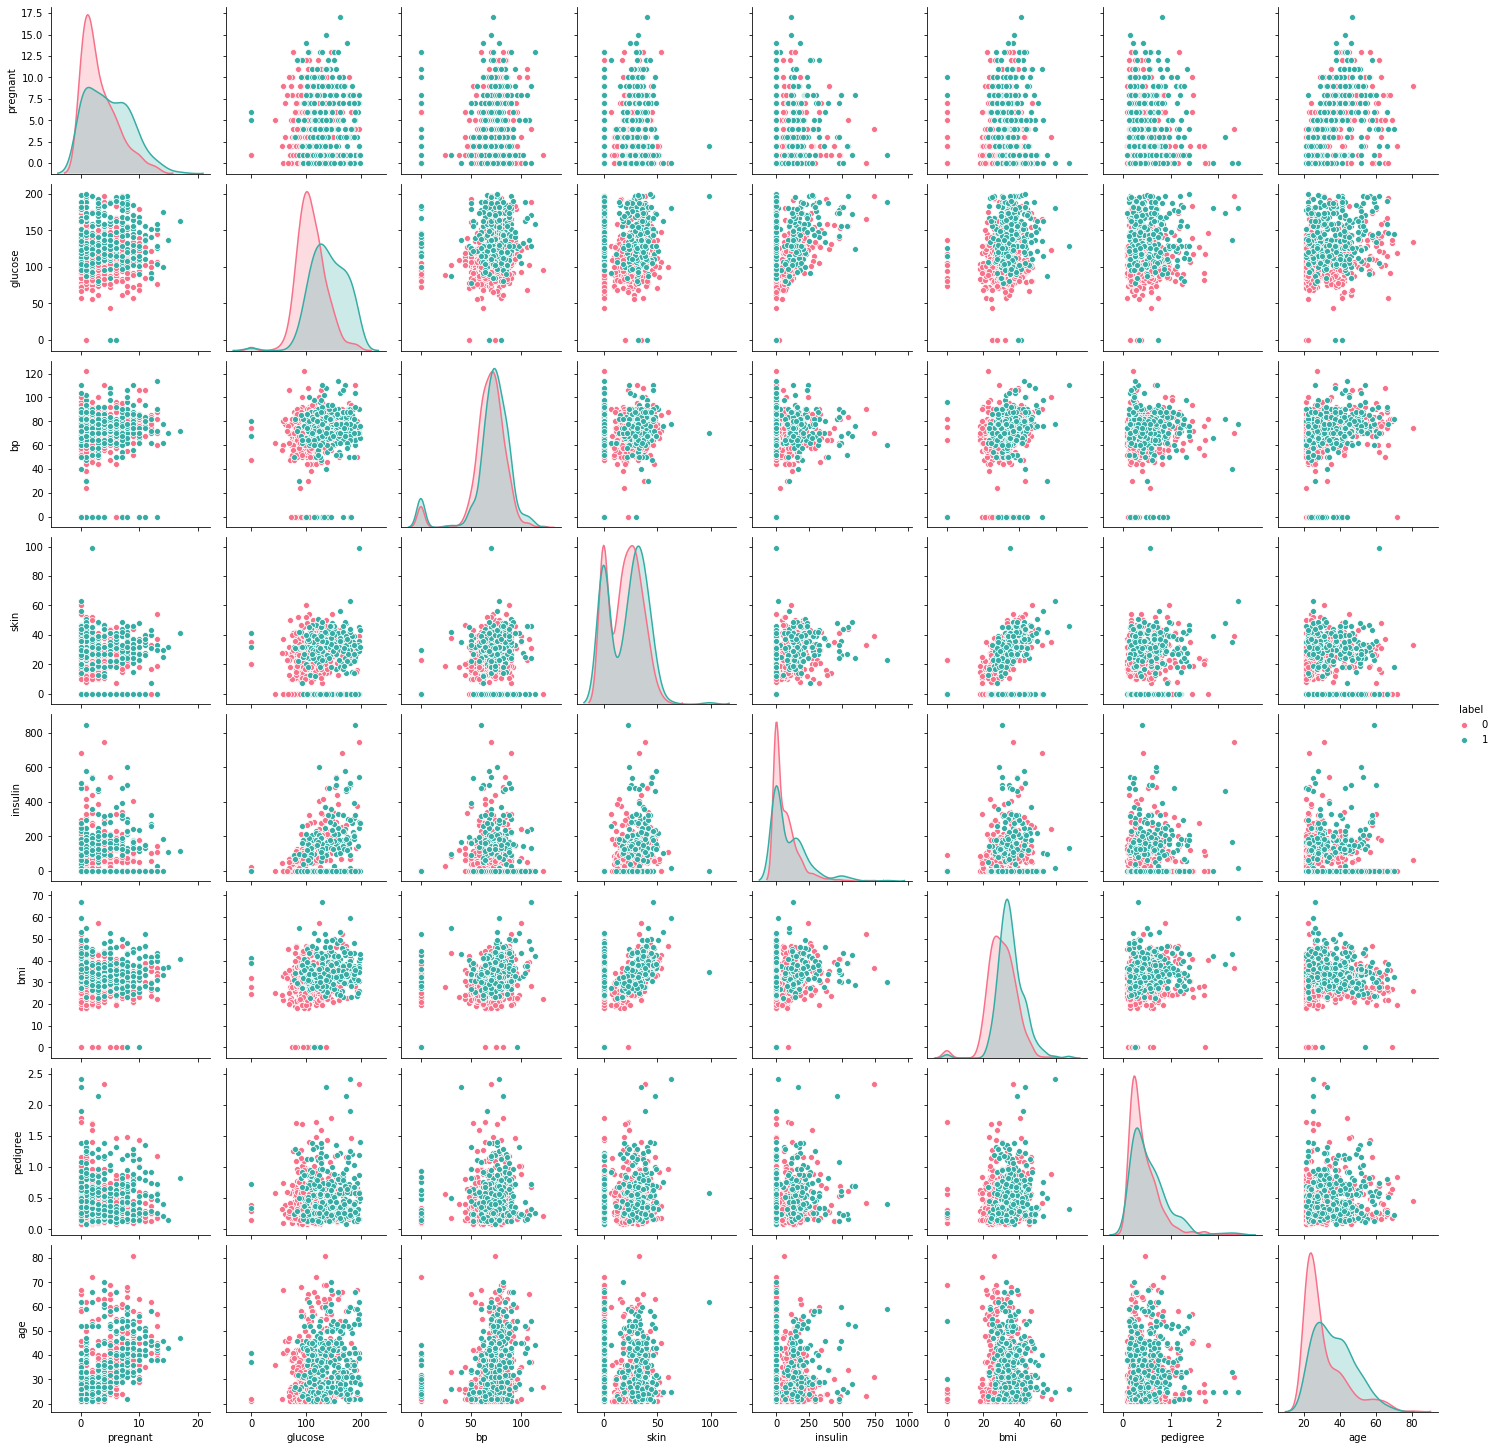

In [7]:
 g = sns.pairplot(df, hue="label", palette="husl")

It is evident that, many features are suffering from outliers. They need to be treated and the outliers should be investigated or removed. For the sake of this analysis, I have skipped the most part of visualization and outlier analysis.

In [8]:
# make train test split
X = df[feature_cols] # Features
y = df[target_col] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=df[target_col])

In [9]:
# create a pipeline and evaluate it using CV
log_reg = LogisticRegression()
scaler = StandardScaler()
training_pipeline = Pipeline([('Scaler', scaler),('LR'  , log_reg)])
evaluate_model_cv(X_train, y_train, training_pipeline, 'Logistic Regression')

Model: Logistic Regression | Scoring: accuracy score: 0.7656448754040246 std: 0.03552886383170378


0.7656448754040246

In [10]:
# check hyperparameters of pipeline
training_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Scaler', 'LR', 'Scaler__copy', 'Scaler__with_mean', 'Scaler__with_std', 'LR__C', 'LR__class_weight', 'LR__dual', 'LR__fit_intercept', 'LR__intercept_scaling', 'LR__l1_ratio', 'LR__max_iter', 'LR__multi_class', 'LR__n_jobs', 'LR__penalty', 'LR__random_state', 'LR__solver', 'LR__tol', 'LR__verbose', 'LR__warm_start'])

In [11]:
# tune the hyperparameters to get best parameters by using random search
param_dict = {'LR__penalty': ['l1', 'l2', 'elasticnet'], 
              'LR__C': uniform(loc=0, scale=4),
              'LR__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
optimizer = RandomSearchOptimizer(X_train, y_train, training_pipeline, param_dict)
y_pred = optimizer.predict(X_test, verbose=True)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s


Scoring: accuracy score: 0.7685017203628401        best params: {'LR__C': 0.03603198784417172, 'LR__penalty': 'l2', 'LR__solver': 'lbfgs'}


[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LR__C,param_LR__penalty,param_LR__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005755,0.000579,0.001227,0.000341,0.036032,l2,lbfgs,"{'LR__C': 0.03603198784417172, 'LR__penalty': ...",0.733813,0.760870,0.804348,0.789855,0.753623,0.768502,0.025392,1
1,0.003817,0.000608,0.001111,0.000250,0.0320108,l2,liblinear,"{'LR__C': 0.03201084260839826, 'LR__penalty': ...",0.697842,0.731884,0.804348,0.804348,0.789855,0.765655,0.043172,2
2,0.005721,0.000904,0.001513,0.000564,0.340177,l2,sag,"{'LR__C': 0.34017684547911164, 'LR__penalty': ...",0.705036,0.753623,0.797101,0.804348,0.768116,0.765645,0.035529,3
3,0.007241,0.001045,0.001467,0.000333,0.409338,l2,lbfgs,"{'LR__C': 0.40933771531130336, 'LR__penalty': ...",0.705036,0.753623,0.797101,0.804348,0.768116,0.765645,0.035529,3
4,0.004401,0.000623,0.001272,0.000242,1.48034,l2,liblinear,"{'LR__C': 1.4803367916564252, 'LR__penalty': '...",0.705036,0.753623,0.797101,0.804348,0.768116,0.765645,0.035529,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.002292,0.000040,0.000000,0.000000,2.45179,l1,newton-cg,"{'LR__C': 2.4517923709112597, 'LR__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,96
96,0.003238,0.000516,0.000000,0.000000,1.71125,elasticnet,saga,"{'LR__C': 1.7112505303692886, 'LR__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,97
97,0.003055,0.000644,0.000000,0.000000,0.613354,l1,sag,"{'LR__C': 0.6133539116782978, 'LR__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,98
98,0.003586,0.000491,0.000000,0.000000,2.55135,elasticnet,saga,"{'LR__C': 2.5513459362387056, 'LR__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,99


In [12]:
# get model performance on test set
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.80      0.59      0.68        27

    accuracy                           0.81        77
   macro avg       0.80      0.76      0.77        77
weighted avg       0.80      0.81      0.80        77



In [16]:
serialize_model(optimizer.get_best_model(), 'logreg')